In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from collections import OrderedDict
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
sys.path.insert(0, '/home/xiaoyang/WorkSpace/XiaoY/PINNs-TF2.0/PINNs/Utilities/')
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

In [2]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.linear = nn.Linear(100, 1, bias = True)
        self.centers = torch.nn.Parameter(torch.randn((100, 2)), requires_grad=True) #随机初始化中心并将其加入网络中训练
        self.beta = torch.nn.Parameter(torch.randn(100), requires_grad=True)  #随机初始化宽度参数并将其加入网络中训练
        #self.centers = torch.randn((10, 2)) #随机初始化中心
        #self.beta = torch.randn(10)  #随机初始化宽度参数


    def kernel_fun(self, x):
        self.X_train = x
        x1 = self.X_train.repeat(1, 100)
        x2 = torch.reshape(x1,[-1, 100, 2])
        dist = (x2-self.centers)**2
        dist = dist.sum(2, keepdim = False)
        return torch.exp(-dist/(2*self.beta**2))


    def forward(self, x):
        x = self.kernel_fun(x)
        x = self.linear(x)
        return x

In [4]:
class PINNS(DNN):
    def __init__(self, X_u, u, layers, X_f, lb, ub, nu):
        super(PINNS, self).__init__()
        #初始化数据
        self.nu = nu
        self.u = torch.tensor(u).float().to(device)
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad = True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad = True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad = True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad = True).float().to(device)
        self.dnn = DNN().to(device)
        #将epoch初始化
        self.epoch = 0
        #self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)
        #设置LBFGS优化器，学习率为1，最大训练次数为5w次，终止梯度差1e-5
        #self.optimizer = torch.optim.SGD(self.dnn.parameters(),lr=0.05,momentum=0.9)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )
        #定义u（x，t）
    def u_model(self, x, t):
        u = self.dnn(torch.cat([x, t], dim = 1))
        return u
    
        #定义f（x，t）
    def f_model(self, x, t):
        u = self.u_model(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        #此时u_x为一个列表（或者说计算图），所以在末尾加上[0]，得到tensor
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f

        #定义损失函数
    def loss_fun(self):
        self.optimizer.zero_grad()
        loss_u = torch.mean((self.u_model(self.x_u, self.t_u) - self.u)**2)
        loss_f = torch.mean((self.f_model(self.x_f, self.t_f)) **2)
        loss = loss_u + loss_f
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一百次迭代输出损失函数的值
        if self.epoch % 500 ==0:
            print('Epoch:{}, loss_u:{:5e}, loss_f:{:5e}, loss:{:5e}'.\
                format(self.epoch, loss_u.item(), loss_f.item(), loss.item()))
        
        return loss

        #训练函数
    def train(self):
        #for i in range(10000):
         #   self.dnn.train()
          #  self.optimizer.step(self.loss_fun)
        self.dnn.train()
        self.optimizer.step(self.loss_fun)

        #模型预测
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, t)
        f = self.f_model(x, t)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u,f

In [5]:
#数据处理，基本摘抄原作者TensorFlow版
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('/home/xiaoyang/WorkSpace/XiaoY/PINNs-TF2.0/1d-burgers/data\
/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# 边界点
lb = X_star.min(0)
ub = X_star.max(0) 

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
#边界点
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
#内点+边界点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])
#随机选择N_u个边界点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [6]:
model = PINNS(X_u_train, u_train, layers, X_f_train, lb, ub, nu)

In [7]:
%%time
               
#开始训练
model.train()

Epoch:500, loss_u:3.656235e-02, loss_f:1.652350e-02, loss:5.308585e-02
Epoch:1000, loss_u:3.532571e-02, loss_f:1.556336e-02, loss:5.088906e-02
Epoch:1500, loss_u:3.504949e-02, loss_f:1.476486e-02, loss:4.981435e-02
Epoch:2000, loss_u:3.479491e-02, loss_f:1.454926e-02, loss:4.934417e-02
Epoch:2500, loss_u:3.444311e-02, loss_f:1.440316e-02, loss:4.884627e-02
Epoch:3000, loss_u:3.398704e-02, loss_f:1.369385e-02, loss:4.768089e-02
Epoch:3500, loss_u:3.398623e-02, loss_f:1.355175e-02, loss:4.753798e-02
Epoch:4000, loss_u:3.391797e-02, loss_f:1.335956e-02, loss:4.727753e-02
Epoch:4500, loss_u:3.369910e-02, loss_f:1.342820e-02, loss:4.712730e-02
Epoch:5000, loss_u:3.371940e-02, loss_f:1.332228e-02, loss:4.704168e-02
Epoch:5500, loss_u:3.357237e-02, loss_f:1.337235e-02, loss:4.694472e-02
Epoch:6000, loss_u:3.348328e-02, loss_f:1.329362e-02, loss:4.677690e-02
Epoch:6500, loss_u:3.347227e-02, loss_f:1.324984e-02, loss:4.672211e-02
CPU times: user 1h 51min 11s, sys: 40.4 s, total: 1h 51min 51s
Wa

In [8]:
#获得预测值
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#输出误差
print('Error u: %e' % (error_u))                     
#对预测值进行插值
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 5.265365e-01


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


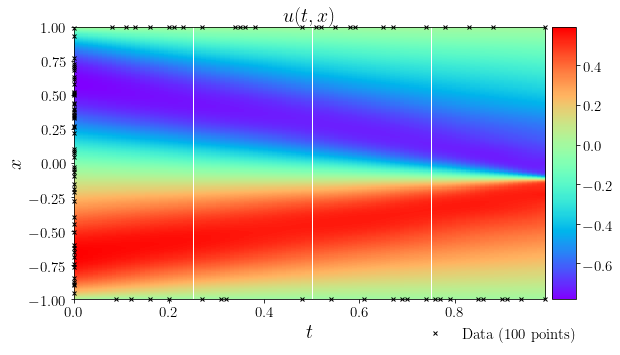

In [9]:
#画图，基本摘抄原作者TensorFlow版
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)

plt.show()

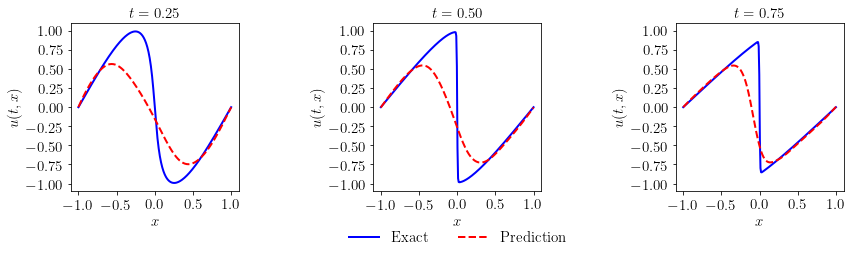

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()